### Support Vector Machines (with linear kernel) 

#### Sequential Minimization Optimization algorithm, along with a significant amount of this code was made available through: 
http://jonchar.net/notebooks/SVM/

#### SMO class (SMOModel)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

class SMOModel:
    '''
    Container object for model used for sequential minimal optimization.
    '''
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self.m = len(self.X)     # store size of training set
        
def linear_kernel(xi, xj, b=1):
    '''
    <xi and xj can be matrix or vector>
        vector (point) dotted with vector (point): returns scalar,
        matrix (dataset) dotted with vector (point): returns vector (dim N),
        matrix (dataset) dotted with itself: returns matrix (dim N*N).
        
    Returns linear combination (inner product) <xi,xj>, plus b.
    '''
    return np.dot(xi, xj.T) + b

#### Training (outer loop function)

In [2]:
def train(model):
    '''
    Outer loop of training process: loops through training points, 
    passes index of each α (as α2) to examine function.  When 
    an examined-flag is returned, an objective result is computed.
    '''
    kOne, kTwo = 0, 1   #set initial counter values 

    #run while loop as long as either counter has a positive value
    while kOne > 0 or kTwo > 0:

        kOne = 0   # reset first counter
        
        if kTwo > 0:
            
            # loop over all training points
            for i in range(model.alphas.shape[0]):
                
                # attempt to optimize values for w and b, using this index of α
                examined_flag, model = examine(i, model)
                                
                # increment counter, if flag returned as 1 (in many cases, 0 will be returned)
                kOne += examined_flag
                
        else: # if no alphas were evaluated during prior iteration of while loop
            
            # loop over training points where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                
                # attempt to optimize values for w and b, using this index of α
                examined_flag, model = examine(i, model)

                # increment counter, if flag returned as 1 
                kOne += examined_flag
                        
        # kTwo becomes zero after first iteration of while loop, and may subsequently be set back 
        # to one; eventually both counters will remain zero when α's are no longer being evaluated
        if kTwo == 1:
            kTwo = 0
        elif kOne == 0:
            kTwo = 1
            
    # optimized α vector is returned, embedded in an SMOModel object    
    return model

#### Training (cont'd) - middle function

In [3]:
def examine(i2, model):
    '''
    Index accepted as input with respect to α2. Various heuristic methods are 
    used for selecting α1, each passing the index of both α values to take_step 
    function, until a nonzero flag is returned.   
    '''
    # assign i2 as index for second α (value for α is most often zero)   
    alph2 = model.alphas[i2]  
    y2 = model.y[i2]
    E2 = model.errors[i2]

    # proceed if constraints ( α ≥ 0, α ≤ C ) have not been violated
    if ( ( (E2*y2) < -tol and alph2 < model.C) or ( (E2*y2) > tol and alph2 > 0) ):
        
        # proceed with method-1 if there is more than one non-zero α
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            
            # method-1: select α1 based on minimum error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)               
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # (if method-1 was skipped or did not return a flag, try method-2)
        # method-2:  loop nonzero α's, starting at random point  
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # (if neither methods 1 nor 2 retured flags, or were skipped, try method-3)
        # method-3: loop all α's, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))): 
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    # if neither methods 1,2 nor 3 returned flags, return 0 to train function
    return 0, model

#### Training (cont'd) inner loop function - computation for alphas, and b

In [4]:
def take_step(i1, i2, model):
    '''
    Carries out computations relating to α values, and threshold b. 
    '''
    # do not proceed if α-indices are the same
    if i1 == i2:
        return 0, model
    
    # assign i1/i2 as first and second indices
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # set upper and lower α bounds (based on relation between two y-targets)
    if (y1 != y2):                            # if y1/y2 are not equal
        L = max(0, alph2 - alph1)                 # set lower bound to max(0, α2-α1)
        H = min(model.C, model.C + alph2 - alph1) # and set upper bound to min(C, C+α2-α1)
        
    elif (y1 == y2):                          # if y1/y2 are equal
        L = max(0, alph1 + alph2 - model.C)       # set lower bound to max(0, α2+α1-C)
        H = min(model.C, alph1 + alph2)           # and set upper bound to min(C, α2+α1)

    # do not proceed with this pair of α's if upper and lower bounds are equal
    if (L == H):
        return 0, model

    # compute 2nd deriv of obj-function (using training-vector inner products)
    k12 = model.kernel(model.X[i1], model.X[i2])
    k11 = model.kernel(model.X[i1], model.X[i1])
    k22 = model.kernel(model.X[i2], model.X[i2])
    step = 2 * k12 - k11 - k22               # η = 2<xi,xj> - <xi,xi> - <xj,xj>
    
    # if derivative is negative (less common), 
    # compute minimum along constraint                            y2 ⋅ (E1 - E2)
    if (step < 0):                               #  α2_new = α2 + -------------
        a2 = alph2 - y2 * (E1 - E2) / step       #                      η
        
        # clip unconstrained minimum
        if L < a2 < H: 
            a2 = a2         #                   {    H     if     α2_new ≥ H;
        elif (a2 <= L):     # α2_new,clipped =  { α2_new   if   L < α2_new < H;
            a2 = L          #                   {    L     if     α2_new ≤ L
        elif (a2 >= H):
            a2 = H
 
    else:  # if derivative is non-negative, move α's to endpoint with lowest obj-result
        alphas_adj = model.alphas.copy()
        
        alphas_adj[i2] = L
        obj_result_at_L = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        
        alphas_adj[i2] = H
        obj_result_at_H = objective_function(alphas_adj, model.y, model.kernel, model.X)
        
        #          { H    if    obj-result(at L) < obj_result(at H) - eps
        # α2_new = { α2         no change if obj_result is the same at both ends
        #          { L    if    obj-result(at L) > obj_result(at H) + eps   

        if obj_result_at_L > obj_result_at_H + eps:    
            a2 = L                    
        elif obj_result_at_L < (obj_result_at_H - eps):   
            a2 = H
        else:
            a2 = alph2
                        
    # push α2 to 0, or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # do not proceed with this pair of α's if change to α2 was below a certain threshold
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # compute α1 
    a1 = alph1 + s * (alph2 - a2)  # α1_new = α1 + s⋅(α2 - α2_new)

    # compute b1
    #b1 =  E1  +  y1⋅(α1_new - α1)*<xi,xi>  +  y2⋅(α2_new - α2)*<xi,xj> +   b
    b1  =  E1  +  y1*(a1 - alph1) *  k11    +  y2*(a2 - alph2) *  k12   +  model.b

    # compute b2
    #b2 =  E2  +  y1⋅(α1_new - α1)*<xi,xj>  +  y2⋅(α2_new - α2)*<xj,xj> +   b
    b2  =  E2  +  y1*(a1 - alph1) *  k12    +  y2*(a2 - alph2) *  k22   +  model.b
    
    #compute new b
    #                          {      b1       if α1 > 0 and α1 < C;  
    #                b_new  =  {      b2       if α2 > 0 and α2 < C;      
    #                          {  (b1+b2)*0.5  otherwise
    if 0 < a1 and a1 < C:  
        b_new = b1
    elif  0 < a2 and a2 < C:
        b_new = b2
    else:  
        b_new = (b1+b2) * 0.5

    # embed new α's into model 
    model.alphas[i1], model.alphas[i2] = a1, a2
    
    # if α's are unbound (eg,  0 < α < C), set error cache to 0
    for ix, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[ix] = 0.0
    
    # update error cache (Ek) with respect to all other training points
    oth_pts = [k for k in range(model.m) if (k != i1 and k != i2)]
    #             Ek_new  = Ek_old + y1 ⋅ (α1_new - α1_old) ⋅ <x1, x_k> 
    #                              + y2 ⋅ (α2_new - α2_old) ⋅ <x2, x_k> 
    #                              + b_old  -  b_new 
    model.errors[oth_pts] = model.errors[oth_pts] + \
                            y1*(a1 - alph1) * model.kernel(model.X[i1], model.X[oth_pts])+\
                            y2*(a2 - alph2) * model.kernel(model.X[i2], model.X[oth_pts])+\
                            model.b - b_new
    
    # embed new b into model 
    model.b = b_new
    
    # return flag, as well as updated-embedded model
    return 1, model

#### Objective function

In [5]:
def objective_function(alphas, target, kernel, X):
    '''
    Returns the SVM objective function based in the input model defined by:
     alphas: vector of Lagrange multipliers
     target: vector of class labels (-1 or 1) for training data
     kernel: kernel function
     X: training data for model
     
    targets * alphas squared <result is vector>
    inner product of dataset with itself <result is N*N matrix>
    vector multiplied by matrix <result is N*N matrix>  (note: multiplied, not dotted)
    sum matrix <result is vector of dim N>
    sum vector <result is scalar>   
    ''' 
    return np.sum(alphas) - 0.5 * np.sum(target * target * kernel(X, X) * alphas * alphas)

#### Decision function

In [6]:
def decision_function(alphas, target, kernel, xi, xj, b):
    '''
    Applies SVM decision function.
    scenarios:  
        vector returned as an inner product of dataset with point
        matrix returned as an inner product of dataset with itself
        alphas*targets is vector
        alphas*targets dotted with vector <result is scalar>
        alphas*targets dotted with matrix <result is vector>
    '''
    result = np.dot( (alphas * target), kernel(xi, xj) ) - b
    return result

#### main - setting regularization parameters

In [7]:
# penalty factor, C
#   larger C  → less regularization, fewer errors, hard margin behavior
#   smaller C → more reg, softer margin behavior with respect to outliers                      
C   = 1000 

# epsillon, ε 
#   smaller ε → less regularization, more overfit
#   ε is sensitive to size of training set, range of target variables, and gaussian noise
eps = 0.01 

# tolerance, an additional parameter 
#   higher setting → less reg, more overfit, allows training on more pairs of α's
#   lower setting  → more reg, less overfit, allows training on fewer pairs of α's 
tol = 0.01

#### main (continued) - load data

In [8]:
def scale_dataset(A):
    A_T, new_A, j =  A.T, [], 0
    means = [np.mean(row) for row in A_T]
    stds  = [np.std(row) for row in A_T]
    for row in A_T:
        new_A.append( [(i - means[j]) / stds[j] for i in row] )
        j += 1
    return np.array(new_A).T

inputs, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1)  
y[y == 0] = -1  #change classes to +1 and -1
X, y = scale_dataset(inputs), np.array(y)
m = len(X)  # m will be number of training points, alphas, and size of error cache

#axes sorting/class (for plotting purposes) 
minv, maxv  = np.min(X[:,0])-0.20, np.max(X[:,0])+.20
minh, maxh  = np.min(X[:,1])-0.20, np.max(X[:,1])+.20
ix, nv, nh, pv, ph = 0, [], [], [], []    # remove ix = 0
for ix in range(m):
    if y[ix] == -1:
        nv.append(X[:,0][ix])
        nh.append(X[:,1][ix])
    else:
        pv.append(X[:,0][ix])
        ph.append(X[:,1][ix])
    ix += 1                                        

#### main (continued) - instantiate and train

In [9]:
#  select: linear_kernel, or other kernel
kernel = linear_kernel  

#  instantiate model
#  passing in:   X, y, C, kernel, initial_alphas, initial_b,   errors    
model = SMOModel(X, y, C, kernel,   np.zeros(m) ,     0.0  , np.zeros(m) )

#  initialize error cache
initial_error = decision_function(model.alphas, y, kernel, X, X, model.b) - y
model.errors = initial_error

#  train model
np.random.seed(0)
output = train(model)
alphas, b = output.alphas, output.b

#### visualize

       data point           class  alpha (lagrange multiplier)

[ 1.16466313  0.43617802]   -1      0.482328659806

[ 0.60754434  0.85371564]   -1      3.29597460436e-17

[-0.44558325 -1.02919521]   1      0.409401339813

[-0.74821928 -0.51438394]   1      0.0729273199934


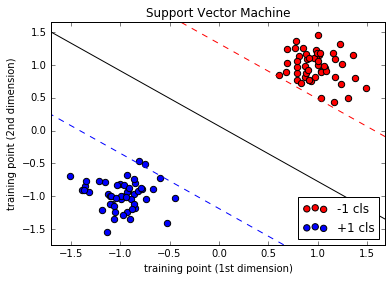

In [10]:
axes = plt.gca()
axes.set_xlim([minv, maxv]) 
axes.set_ylim([minh, maxh]) 
plt.scatter(nv, nh, c='r', marker = 'o', s=40, label='-1 cls')
plt.scatter(pv, ph, c='b', marker = 'o', s=40, label='+1 cls')
plt.title('Support Vector Machine')
plt.xlabel('training point (1st dimension)')
plt.ylabel('training point (2nd dimension)')

# define vertical and horizontal line space
linsp_v = np.linspace( minv, maxv, 100 )
linsp_h = np.linspace( minh, maxh, 100 )

# define decision boundary by applying decision-function to X-space
boundary = [[decision_function(alphas, y, kernel, X, np.array([xr, yr]), 
                               b) for yr in linsp_h] for xr in linsp_v]
boundary = np.array(boundary).reshape(len(linsp_v), len(linsp_h))

# show margin of decision boundary
axes.contour(linsp_v, linsp_h, boundary, (-1, 0, 1), linewidths=(1, 1, 1), 
           linestyles=('--', '-', '--'), colors=('r','k','b'))
plt.legend(loc='lower right')

print '       data point           class  alpha (lagrange multiplier)'
for i in range(m):
    if alphas[i] > 0:
        print '\n', X[i], ' ', y[i], '    ', alphas[i]

#### weights vector

In [11]:
def w_vector(X, y, alphas):
    '''
    Returns vector of weights. ( y * alpha is scalar, which, dotted with a
    training vector, results in a vector; sum of vectors results in a vector ) 
    '''
    return sum(np.dot((y[i] * alphas[i]), X[i]) for i in range(len(alphas)))

w_vector(X, y, alphas)

array([-0.79873841, -0.6692477 ])

#### make prediction

In [12]:
# specify points with which prediction is being made on
pts = [ [1.5, -1.5], [1.5, -1.0], [0, 0], [-1.0, 1.0] ]

print 'predictions using decision function'
for pt in pts:
    result = decision_function(alphas, y, kernel, X, np.array(pt), b)
    print 'point:', pt, '  decision value:', round(result, 3),
    if np.sign(result) < 0: print 'class: -1'
    else: print 'class: +1'
        
print '\npredictions using dot(w,x)-b:'
for pt in pts:
    w = w_vector(X, y, alphas)
    result = np.dot(w, pt) - b
    print 'point:', pt, '  dot(w,x)-b:', round(result, 3),
    if np.sign(result) < 0: print '-1'
    else: print '+1'

predictions using decision function
point: [1.5, -1.5]   decision value: -0.135 class: -1
point: [1.5, -1.0]   decision value: -0.47 class: -1
point: [0, 0]   decision value: 0.059 class: +1
point: [-1.0, 1.0]   decision value: 0.188 class: +1

predictions using dot(w,x)-b:
point: [1.5, -1.5]   dot(w,x)-b: -0.135 -1
point: [1.5, -1.0]   dot(w,x)-b: -0.47 -1
point: [0, 0]   dot(w,x)-b: 0.059 +1
point: [-1.0, 1.0]   dot(w,x)-b: 0.188 +1


#### in sample error

In [13]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    accuracy_result = correct / float(len(actual)) * 100.
    return accuracy_result

prediction_values = []
for pt in X:
    result = decision_function(alphas, y, kernel, X, np.array(pt), b)
    prediction_values.append( np.sign(result) )
    
accuracy_metric(y, prediction_values)

100.0

#### add an outlier

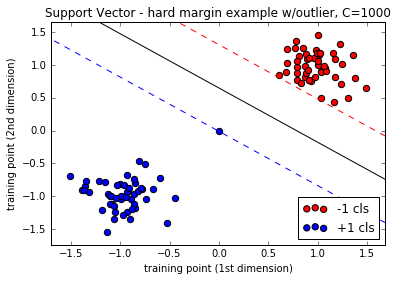

In [14]:
X_outlier = np.append(X, [0, 0])
X_outlier = X_outlier.reshape(X.shape[0]+1, X.shape[1])
y_outlier = np.append(y, 1)
minv, maxv = np.min(X_outlier[:,0])-0.20, np.max(X_outlier[:,0])+.20
minh, maxh = np.min(X_outlier[:,1])-0.20, np.max(X_outlier[:,1])+.20
ix, nv, nh, pv, ph = 0, [], [], [], []
m = len(X_outlier)
for ix in range(m):
    if y_outlier[ix] == -1:
        nv.append(X_outlier[:,0][ix])
        nh.append(X_outlier[:,1][ix])
    else:
        pv.append(X_outlier[:,0][ix])
        ph.append(X_outlier[:,1][ix])
    ix += 1
model = SMOModel(X_outlier, y_outlier, C, kernel, np.zeros(m), 0.0, np.zeros(m) )
initial_error = decision_function(model.alphas, y_outlier, kernel, X_outlier, X_outlier, 
                                  model.b) - y_outlier
model.errors = initial_error
output = train(model)
alphas, b = output.alphas, output.b
axes = plt.gca()
axes.set_xlim([minv, maxv]) 
axes.set_ylim([minh, maxh]) 
plt.scatter(nv, nh, c='r', marker = 'o', s=40, label='-1 cls')
plt.scatter(pv, ph, c='b', marker = 'o', s=40, label='+1 cls')
plt.title('Support Vector - hard margin example w/outlier, C=1000')
plt.xlabel('training point (1st dimension)')
plt.ylabel('training point (2nd dimension)')

linsp_v = np.linspace( minv, maxv, 100 )
linsp_h = np.linspace( minh, maxh, 100 )
boundary = [[decision_function(alphas, y_outlier, kernel, 
                               X_outlier, np.array([xr, yr]), 
                               b) for yr in linsp_h] for xr in linsp_v]
boundary = np.array(boundary).reshape(len(linsp_v), len(linsp_h))
axes.contour(linsp_v, linsp_h, boundary, (-1, 0, 1), linewidths=(1, 1, 1), 
           linestyles=('--', '-', '--'), colors=('r','k','b'))
plt.legend(loc='lower right')

In [15]:
print 'weights change when adding outlier'
w_vector(X_outlier, y_outlier, alphas)

weights change when adding outlier


array([-1.52058595, -1.24989328])

#### soft margin example

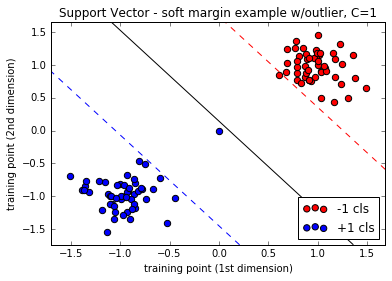

In [16]:
#           1             N
# minimize --- ⋅ wTw + C  ∑ ⋅ ξ_n
#           2            n=1

# margin is violated when y_n(wTx_n + b) ≥ 1 fails, however, this failure 
# can be quantified by introducing a slack ξ_n ≥ 0 for every point
#                     N
# total violation  =  ∑ ⋅ ξ_n   (lower setting for C permits more slack)
#                    n=1
C = 1
model = SMOModel(X_outlier, y_outlier, C, kernel, np.zeros(m), 0.0, np.zeros(m) )
initial_error = decision_function(model.alphas, y_outlier, kernel, X_outlier, 
                                  X_outlier, model.b) - y_outlier
model.errors = initial_error
output = train(model)
alphas, b = output.alphas, output.b
axes = plt.gca()
axes.set_xlim([minv, maxv]) 
axes.set_ylim([minh, maxh]) 
plt.scatter(nv, nh, c='r', marker = 'o', s=40, label='-1 cls')
plt.scatter(pv, ph, c='b', marker = 'o', s=40, label='+1 cls')
plt.title('Support Vector - soft margin example w/outlier, C=1')
plt.xlabel('training point (1st dimension)')
plt.ylabel('training point (2nd dimension)')

linsp_v = np.linspace( minv, maxv, 100 )
linsp_h = np.linspace( minh, maxh, 100 )
boundary = [[decision_function(alphas, y_outlier, kernel, 
                               X_outlier, np.array([xr, yr]), 
                               b) for yr in linsp_h] for xr in linsp_v]
boundary = np.array(boundary).reshape(len(linsp_v), len(linsp_h))
axes.contour(linsp_v, linsp_h, boundary, (-1, 0, 1), linewidths=(1, 1, 1), 
           linestyles=('--', '-', '--'), colors=('r','k','b'))
plt.legend(loc='lower right')

In [17]:
print 'weights change again when C changes'
w_vector(X_outlier, y_outlier, alphas)

weights change again when C changes


array([-0.62936862, -0.86616424])